In [1]:
# Before starting import everything necessary
import setGPU

import numpy as np
import os
import simplejson as json
import sys
import torch
import yaml

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import Counter
from ssd.net import build_ssd

setGPU: Setting GPU to: 0


In [2]:
# Set presentation settings
%matplotlib inline

#import matplotlib
import matplotlib.pyplot as plt

with open('../plots/palette.json') as json_file:
    color_palette = json.load(json_file)
plt.style.use('../plots/ssdjet.mplstyle')

In [3]:
CONFIG_FILE = '../ssd-config.yml'
MODEL = '../models/pfssd-tp.pth'

config = yaml.safe_load(open(CONFIG_FILE))
ssd_settings = config['ssd_settings']
ssd_settings['n_classes'] += 1

In [4]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
net = build_ssd(0, config['ssd_settings'], inference=True)
net.load_weights(MODEL)
net.eval()

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=32)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=32)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=64)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): PReLU(num_parameters=64)
    (13): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (14): Conv2d(64, 

In [5]:
vgg_filters = []
for layer in net.vgg:
    if type(layer) == torch.nn.modules.conv.Conv2d:
        for kernel in layer.weight:
            for filtr in kernel:
                scale = torch.max(filtr)
                if scale == 0.:
                    scale = -torch.min(filtr)
                if scale != 0.:
                    filtr = filtr / scale
                filtr = filtr.flatten() + 1
                filtr = ''.join(['{:.0f}'.format(x) for x in filtr.tolist()])
                vgg_filters.append(filtr)

In [6]:
out_filters = []
for n in [net.loc, net.cnf, net.reg]:
    for layer in n:
        if type(layer) == torch.nn.modules.conv.Conv2d:
            for kernel in layer.weight:
                for filtr in kernel:
                    scale = torch.max(filtr)
                    if scale == 0.:
                        scale = -torch.min(filtr)
                    if scale != 0.:
                        filtr = filtr / scale
                    filtr = filtr.flatten() + 1
                    filtr = ''.join(['{:.0f}'.format(x) for x in filtr.tolist()])
                    out_filters.append(filtr)

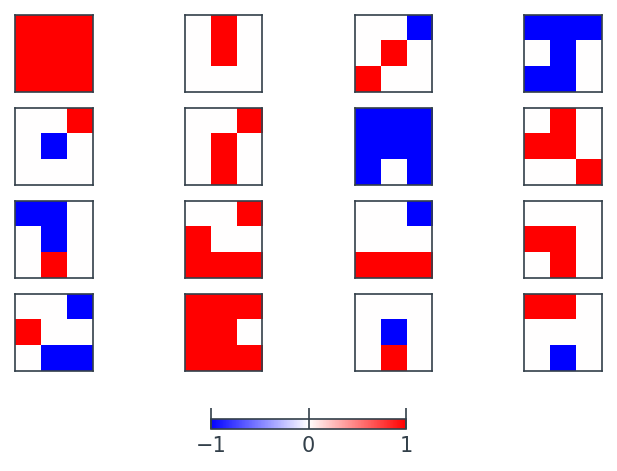

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=4)

for f, ax in zip(Counter(vgg_filters).most_common(16), axs.flat):
    f = [int(i)-1 for i in list(f[0])]
    f = np.array(f).reshape(3,3)
    
    pcm = ax.imshow(f, vmin=-1, vmax=1, cmap='bwr')
    ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax.grid(False)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

fig.colorbar(pcm, ax=axs, orientation="horizontal", pad=0.1, shrink=.3)
plt.show()

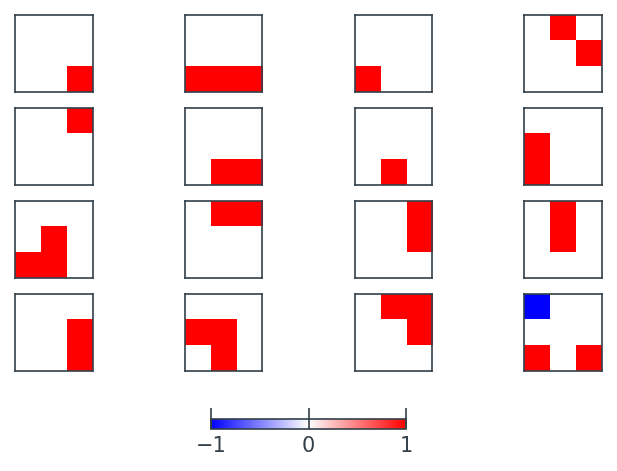

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=4)

for f, ax in zip(Counter(out_filters).most_common(16), axs.flat):
    f = [int(i)-1 for i in list(f[0])]
    f = np.array(f).reshape(3,3)

    pcm = ax.imshow(f, vmin=-1, vmax=1, cmap='bwr', interpolation='nearest')
    ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax.grid(False)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

fig.colorbar(pcm, ax=axs, orientation="horizontal", pad=0.1, shrink=.3)
plt.show()